<a href="https://colab.research.google.com/github/sandra660/fraud_detection_project/blob/sandrabranch/note1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Notebook 1 - Exploration & Feature Engineering (Group 2)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")




In [ ]:
# Load raw CSVs
benef = pd.read_csv('/content/Train_Beneficiarydata-1542865627584.csv')
ip    = pd.read_csv('/content/Train_Inpatientdata-1542865627584.csv')
op    = pd.read_csv('/content/Train_Outpatientdata-1542865627584.csv')
labels = pd.read_csv('/content/Train-1542865627584.csv')

print("Beneficiary shape:", benef.shape)
print("Inpatient shape  :", ip.shape)
print("Outpatient shape :", op.shape)
print("Label shape      :", labels.shape)

display(labels.head())


Beneficiary shape: (138556, 25)
Inpatient shape  : (40474, 30)
Outpatient shape : (517737, 27)
Label shape      : (5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


PotentialFraud value counts:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64


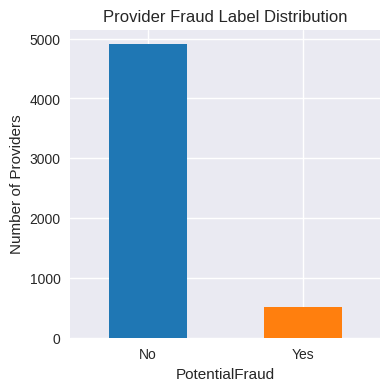

In [ ]:
print("PotentialFraud value counts:")
print(labels['PotentialFraud'].value_counts())

plt.figure(figsize=(4,4))
labels['PotentialFraud'].value_counts().plot(kind='bar', color=['tab:blue','tab:orange'])
plt.title("Provider Fraud Label Distribution")
plt.xlabel("PotentialFraud")
plt.ylabel("Number of Providers")
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Work on copies to avoid warnings
ip = ip.copy()
op = op.copy()

# Inpatient dates → ClaimDuration
ip['ClaimStartDt'] = pd.to_datetime(ip['ClaimStartDt'])
ip['ClaimEndDt']   = pd.to_datetime(ip['ClaimEndDt'])
ip['ClaimDuration'] = (ip['ClaimEndDt'] - ip['ClaimStartDt']).dt.days

# Outpatient dates → ClaimDuration
op['ClaimStartDt'] = pd.to_datetime(op['ClaimStartDt'])
op['ClaimEndDt']   = pd.to_datetime(op['ClaimEndDt'])
op['ClaimDuration'] = (op['ClaimEndDt'] - op['ClaimStartDt']).dt.days

display(ip[['Provider','ClaimStartDt','ClaimEndDt','ClaimDuration']].head())
display(op[['Provider','ClaimStartDt','ClaimEndDt','ClaimDuration']].head())


,Provider,ClaimStartDt,ClaimEndDt,ClaimDuration
0,PRV55912,2009-04-12,2009-04-18,6
1,PRV55907,2009-08-31,2009-09-02,2
2,PRV56046,2009-09-17,2009-09-20,3
3,PRV52405,2009-02-14,2009-02-22,8
4,PRV56614,2009-08-13,2009-08-30,17


,Provider,ClaimStartDt,ClaimEndDt,ClaimDuration
0,PRV56011,2009-10-11,2009-10-11,0
1,PRV57610,2009-02-12,2009-02-12,0
2,PRV57595,2009-06-27,2009-06-27,0
3,PRV56011,2009-01-06,2009-01-06,0
4,PRV56011,2009-01-22,2009-01-22,0


In [ ]:
ip_agg = ip.groupby('Provider').agg(
    ip_total_reimb = ('InscClaimAmtReimbursed', 'sum'),
    ip_total_deduct = ('DeductibleAmtPaid', 'sum'),
    ip_num_claims = ('ClaimID', 'nunique'),
    ip_avg_duration = ('ClaimDuration', 'mean'),
    ip_max_duration = ('ClaimDuration', 'max')
).reset_index()

display(ip_agg.head())


,Provider,ip_total_reimb,ip_total_deduct,ip_num_claims,ip_avg_duration,ip_max_duration
0,PRV51001,97000,5340.0,5,5.000000,14
1,PRV51003,573000,66216.0,62,5.161290,27
2,PRV51007,19000,3204.0,3,5.333333,7
3,PRV51008,25000,2136.0,2,4.000000,5
4,PRV51011,5000,1068.0,1,5.000000,5


In [ ]:
op_agg = op.groupby('Provider').agg(
    op_total_reimb = ('InscClaimAmtReimbursed', 'sum'),
    op_total_deduct = ('DeductibleAmtPaid', 'sum'),
    op_num_claims = ('ClaimID', 'nunique'),
    op_avg_duration = ('ClaimDuration', 'mean'),
    op_max_duration = ('ClaimDuration', 'max')
).reset_index()

display(op_agg.head())


,Provider,op_total_reimb,op_total_deduct,op_num_claims,op_avg_duration,op_max_duration
0,PRV51001,7640,0,20,0.550000,9
1,PRV51003,32670,70,70,2.357143,20
2,PRV51004,52170,310,149,1.429530,20
3,PRV51005,280910,3700,1165,1.088412,20
4,PRV51007,14710,60,69,0.768116,20


In [ ]:
# Keep only needed columns from beneficiary data
chronic_cols = [c for c in benef.columns if c.startswith('ChronicCond_')]
benef_small = benef[['BeneID'] + chronic_cols].copy()

# Unique provider–beneficiary pairs from inpatient & outpatient
prov_bene_ip = ip[['Provider','BeneID']].drop_duplicates()
prov_bene_op = op[['Provider','BeneID']].drop_duplicates()

prov_bene = pd.concat([prov_bene_ip, prov_bene_op], ignore_index=True).drop_duplicates()

# Join with beneficiary chronic conditions
prov_bene = prov_bene.merge(benef_small, on='BeneID', how='left')

# Number of chronic conditions per Bene
prov_bene['num_chronic'] = prov_bene[chronic_cols].sum(axis=1)

# Aggregate at provider level
bene_agg = prov_bene.groupby('Provider').agg(
    bene_count = ('BeneID', 'nunique'),
    avg_num_chronic = ('num_chronic', 'mean')
).reset_index()

display(bene_agg.head())


,Provider,bene_count,avg_num_chronic
0,PRV51001,24,16.458333
1,PRV51003,117,17.632479
2,PRV51004,138,17.681159
3,PRV51005,495,18.115152
4,PRV51007,58,18.120690


In [ ]:
# Start with one row per provider: label
prov_df = labels[['Provider', 'PotentialFraud']].copy()

# Merge inpatient aggregates
prov_df = prov_df.merge(ip_agg, on='Provider', how='left')

# Merge outpatient aggregates
prov_df = prov_df.merge(op_agg, on='Provider', how='left')

# Merge beneficiary aggregates
prov_df = prov_df.merge(bene_agg, on='Provider', how='left')

print("Merged provider-level shape:", prov_df.shape)
display(prov_df.head())


Merged provider-level shape: (5410, 14)


,Provider,PotentialFraud,ip_total_reimb,ip_total_deduct,ip_num_claims,ip_avg_duration,ip_max_duration,op_total_reimb,op_total_deduct,op_num_claims,op_avg_duration,op_max_duration,bene_count,avg_num_chronic
0,PRV51001,No,97000.0,5340.0,5.0,5.000000,14.0,7640.0,0.0,20.0,0.550000,9.0,24,16.458333
1,PRV51003,Yes,573000.0,66216.0,62.0,5.161290,27.0,32670.0,70.0,70.0,2.357143,20.0,117,17.632479
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,52170.0,310.0,149.0,1.429530,20.0,138,17.681159
3,PRV51005,Yes,NaN,NaN,NaN,NaN,NaN,280910.0,3700.0,1165.0,1.088412,20.0,495,18.115152
4,PRV51007,No,19000.0,3204.0,3.0,5.333333,7.0,14710.0,60.0,69.0,0.768116,20.0,58,18.120690


In [ ]:
# Missing numeric values → 0 (no claims / no beneficiaries)
prov_df = prov_df.fillna(0)

# Extra combined features
prov_df['total_reimb'] = prov_df['ip_total_reimb'] + prov_df['op_total_reimb']
prov_df['total_deduct'] = prov_df['ip_total_deduct'] + prov_df['op_total_deduct']
prov_df['total_claims'] = prov_df['ip_num_claims'] + prov_df['op_num_claims']

# Avoid divide-by-zero by adding 1
prov_df['reimb_per_claim'] = prov_df['total_reimb'] / (prov_df['total_claims'] + 1)
prov_df['deduct_per_claim'] = prov_df['total_deduct'] / (prov_df['total_claims'] + 1)
prov_df['ip_to_op_claim_ratio'] = prov_df['ip_num_claims'] / (prov_df['op_num_claims'] + 1)
prov_df['bene_per_claim'] = prov_df['bene_count'] / (prov_df['total_claims'] + 1)

# Numeric label: 1 = Yes (fraud), 0 = No
prov_df['Fraud'] = (prov_df['PotentialFraud'] == 'Yes').astype(int)

display(prov_df.head())


,Provider,PotentialFraud,ip_total_reimb,ip_total_deduct,ip_num_claims,ip_avg_duration,ip_max_duration,op_total_reimb,op_total_deduct,op_num_claims,...,bene_count,avg_num_chronic,total_reimb,total_deduct,total_claims,reimb_per_claim,deduct_per_claim,ip_to_op_claim_ratio,bene_per_claim,Fraud
0,PRV51001,No,97000.0,5340.0,5.0,5.000000,14.0,7640.0,0.0,20.0,...,24,16.458333,104640.0,5340.0,25.0,4024.615385,205.384615,0.238095,0.923077,0
1,PRV51003,Yes,573000.0,66216.0,62.0,5.161290,27.0,32670.0,70.0,70.0,...,117,17.632479,605670.0,66286.0,132.0,4553.909774,498.390977,0.873239,0.879699,1
2,PRV51004,No,0.0,0.0,0.0,0.000000,0.0,52170.0,310.0,149.0,...,138,17.681159,52170.0,310.0,149.0,347.800000,2.066667,0.000000,0.920000,0
3,PRV51005,Yes,0.0,0.0,0.0,0.000000,0.0,280910.0,3700.0,1165.0,...,495,18.115152,280910.0,3700.0,1165.0,240.917667,3.173242,0.000000,0.424528,1
4,PRV51007,No,19000.0,3204.0,3.0,5.333333,7.0,14710.0,60.0,69.0,...,58,18.120690,33710.0,3264.0,72.0,461.780822,44.712329,0.042857,0.794521,0


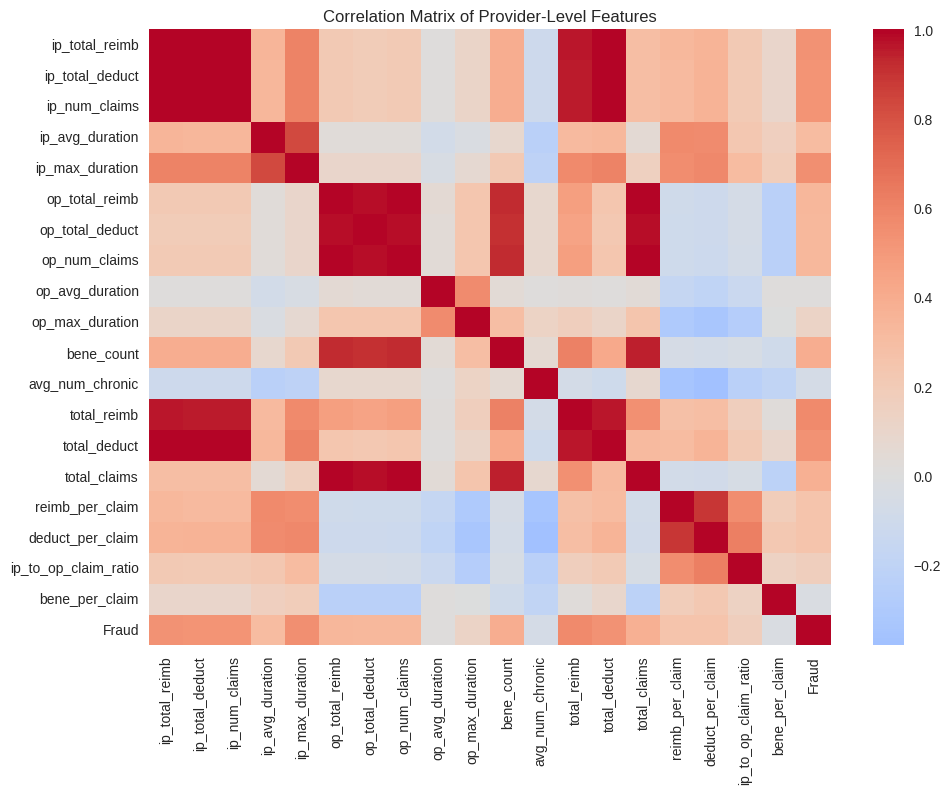

Saved: provider_dataset_cleaned_group2.csv


In [ ]:
plt.figure(figsize=(11,8))
corr = prov_df.drop(columns=['Provider','PotentialFraud']).corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Provider-Level Features")
plt.show()

# Save cleaned dataset for Notebook 2
prov_df.to_csv('/content/provider_dataset_cleaned_group2.csv', index=False)
print("Saved: provider_dataset_cleaned_group2.csv")
